In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.applications import ResNet50
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

2025-06-04 16:32:14.803618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749051134.919170     655 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749051134.959320     655 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749051135.183694     655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749051135.183729     655 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749051135.183731     655 computation_placer.cc:177] computation placer alr

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)


GPU memory growth enabled.


In [3]:
import os

# Caminho local para a pasta raiz do projeto
root_path = "./"  

# Listar diretórios no caminho raiz
print("📁 Diretórios no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-dataset-aug-87-6-6")
if os.path.exists(specific_path):
    print(f"\n📁 Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n❌ Caminho {specific_path} não existe")

# Função para listar diretórios com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretórios
print("\n📂 Estrutura de diretórios:")
list_dirs(root_path, 0)

📁 Diretórios no caminho raiz:
['.DS_Store', '.git', '.gitignore', 'garbage-dataset', 'garbage-dataset-aug-87-6-6', 'garbage-noaug-70-15-15', 'models', 'model_checkpoint.h5', 'requirements.txt', 'SSC.ipynb', 'ssc.py', 'SSC_2_final_optimized.ipynb', 'SSC_3_modelo_LeakyReLU.ipynb', 'SSC_4.ipynb', 'SSC_Model_T_TransferLearning.ipynb']

📁 Conteúdo de ./garbage-dataset-aug-87-6-6:
['README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']

📂 Estrutura de diretórios:
📄 .DS_Store
📁 .git
  📄 COMMIT_EDITMSG
  📄 config
  📄 description
  📄 FETCH_HEAD
  📄 HEAD
  📁 hooks
    📄 applypatch-msg.sample
    📄 commit-msg.sample
    📄 fsmonitor-watchman.sample
    📄 post-update.sample
    📄 pre-applypatch.sample
    📄 pre-commit.sample
    📄 pre-merge-commit.sample
    📄 pre-push.sample
    📄 pre-rebase.sample
    📄 pre-receive.sample
    📄 prepare-commit-msg.sample
    📄 push-to-checkout.sample
    📄 sendemail-validate.sample
    📄 update.sample
  📄 index
  📁 info
    📄 exclude
  📁 logs
    📄

In [4]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
GPU acceleration enabled (Metal)

Device being used: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Matrix multiplication result: tf.Tensor(
[[19. 22.]
 [43. 50.]], shape=(2, 2), dtype=float32)
GPU test successful!


I0000 00:00:1749051186.558994     655 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [6]:
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

IMG_SIZE = 128
BATCH_SIZE = 32

# 1. Carregar dataset com augmentation
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)


val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# 2. Feature Extraction – ResNet50 congelada
base_model = ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # congelado inicialmente


Found 41499 files belonging to 10 classes.
Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [7]:
# 3. Construir modelo com base pré-treinada
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
# 4. Treino com feature extraction
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping]
)

# 5. Fine-tuning – descongela últimas camadas
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Treino com fine-tuning
fine_tune_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

model.save_weights('models/resnet50_finetuned.weights.h5')
# Salvar o modelo completo
model.save('models/resnet50_finetuned_model.h5')
print("Modelo salvo como 'resnet50_finetuned_model.h5' e pesos como 'resnet50_finetuned_weights.h5'.")  

Epoch 1/20


I0000 00:00:1749051237.185458     997 service.cc:152] XLA service 0x7f9c1c002e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749051237.185494     997 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-04 16:33:57.452691: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749051239.096221     997 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/1297 ━━━━━━━━━━━━━━━━━━━━ 45s 35ms/step - accuracy: 0.1449 - loss: 2.3691 

I0000 00:00:1749051244.988130     997 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1297/1297 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.2713 - loss: 2.0995 - val_accuracy: 0.3622 - val_loss: 1.9473
Epoch 2/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.3199 - loss: 1.9654 - val_accuracy: 0.3592 - val_loss: 1.8822
Epoch 3/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - accuracy: 0.3373 - loss: 1.9107 - val_accuracy: 0.4044 - val_loss: 1.8286
Epoch 4/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 30s 23ms/step - accuracy: 0.3516 - loss: 1.8778 - val_accuracy: 0.3976 - val_loss: 1.8064
Epoch 5/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.3593 - loss: 1.8533 - val_accuracy: 0.4118 - val_loss: 1.7618
Epoch 6/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.3658 - loss: 1.8373 - val_accuracy: 0.4175 - val_loss: 1.7524
Epoch 7/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.3711 - loss: 1.8269 - val_accuracy: 0.4196 - val_loss: 1.7405
Epoch 8/20
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.3751 - loss: 1.81

2025-06-04 16:44:27.186644: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv %cudnn-conv.117 = (f16[32,4,4,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,4,4,2048]{3,2,1,0} %bitcast.29118, f16[512,1,1,2048]{3,2,1,0} %bitcast.26938), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/functional_1/resnet50_1/conv5_block3_3_conv_1/convolution/Conv2DBackpropInput" source_file="/home/diogo/venvs/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-04 16:44:27.359923: I external/local_xla/xla/service/gpu/autotuning/conv_algorit

1296/1297 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2383 - loss: 7.3633

2025-06-04 16:45:19.188772: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k2=4,k4=1,k5=4,k6=3,k7=2} for conv %cudnn-conv.117 = (f16[27,4,4,512]{3,2,1,0}, u8[0]{0}) custom-call(f16[27,4,4,2048]{3,2,1,0} %bitcast.29135, f16[512,1,1,2048]{3,2,1,0} %bitcast.26955), window={size=1x1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/functional_1/resnet50_1/conv5_block3_3_conv_1/convolution/Conv2DBackpropInput" source_file="/home/diogo/venvs/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-04 16:45:19.356944: I external/local_xla/xla/service/gpu/autotuning/conv_algorit

1297/1297 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.2385 - loss: 7.3582 - val_accuracy: 0.4793 - val_loss: 1.5609
Epoch 2/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.4585 - loss: 1.6225 - val_accuracy: 0.5511 - val_loss: 1.3295
Epoch 3/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5009 - loss: 1.4524 - val_accuracy: 0.5669 - val_loss: 1.2999
Epoch 4/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5392 - loss: 1.3511 - val_accuracy: 0.5363 - val_loss: 1.3839
Epoch 5/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5612 - loss: 1.2860 - val_accuracy: 0.5528 - val_loss: 1.2883
Epoch 6/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.5930 - loss: 1.1960 - val_accuracy: 0.3862 - val_loss: 2.1550
Epoch 7/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.6076 - loss: 1.1498 - val_accuracy: 0.6020 - val_loss: 1.1908
Epoch 8/10
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.6247 - loss: 1.08

Modelo salvo como 'resnet50_finetuned_model.h5' e pesos como 'resnet50_finetuned_weights.h5'.


93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.6008 - loss: 1.1833
Test accuracy: 0.5927800536155701
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━

2025-06-04 16:51:51.914662: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


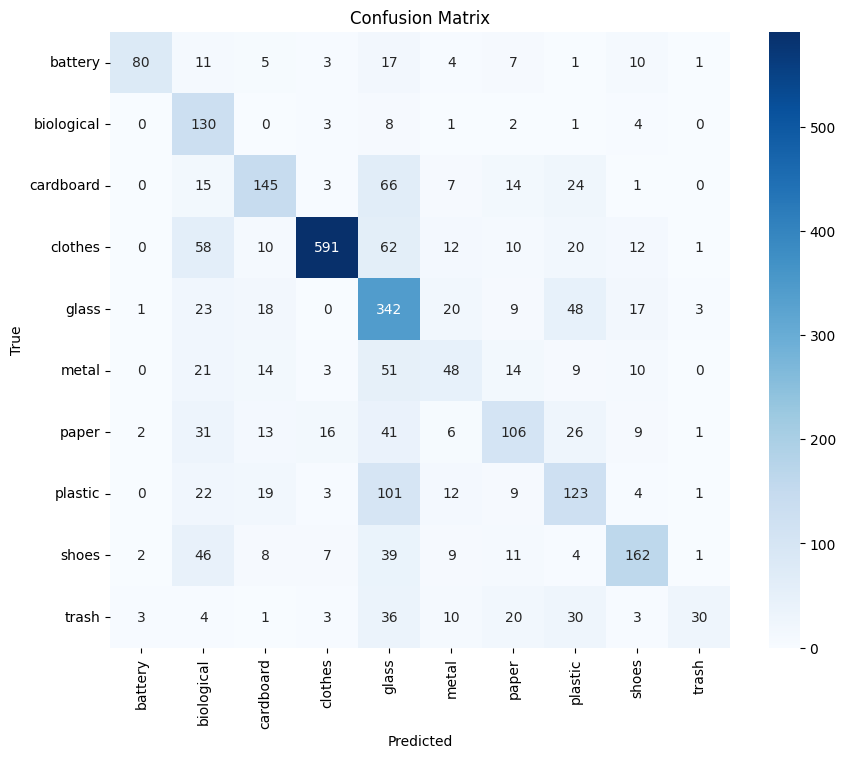

In [9]:
# 7. Avaliação
test_loss, test_acc = model.evaluate(test_dataset)
print("Test accuracy:", test_acc)

# 8. Previsões para métricas
y_pred = []
y_true = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# 9. Relatório e Confusion Matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

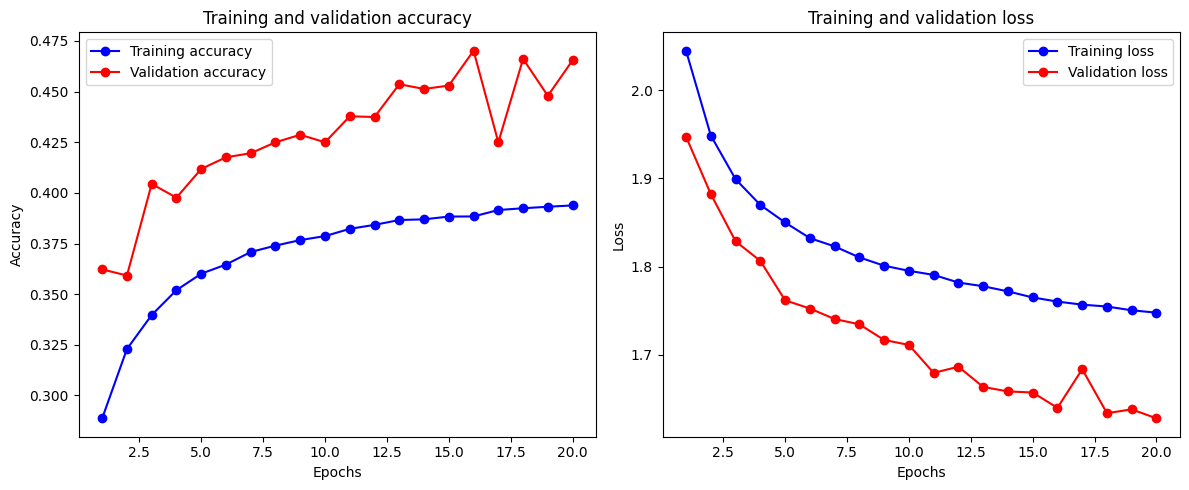

In [10]:
# Corrected plotting code for newer TensorFlow versions
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6040 - loss: 1.1768
Test accuracy: 0.5928
Test loss: 1.2054
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


2025-06-04 16:51:54.953186: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


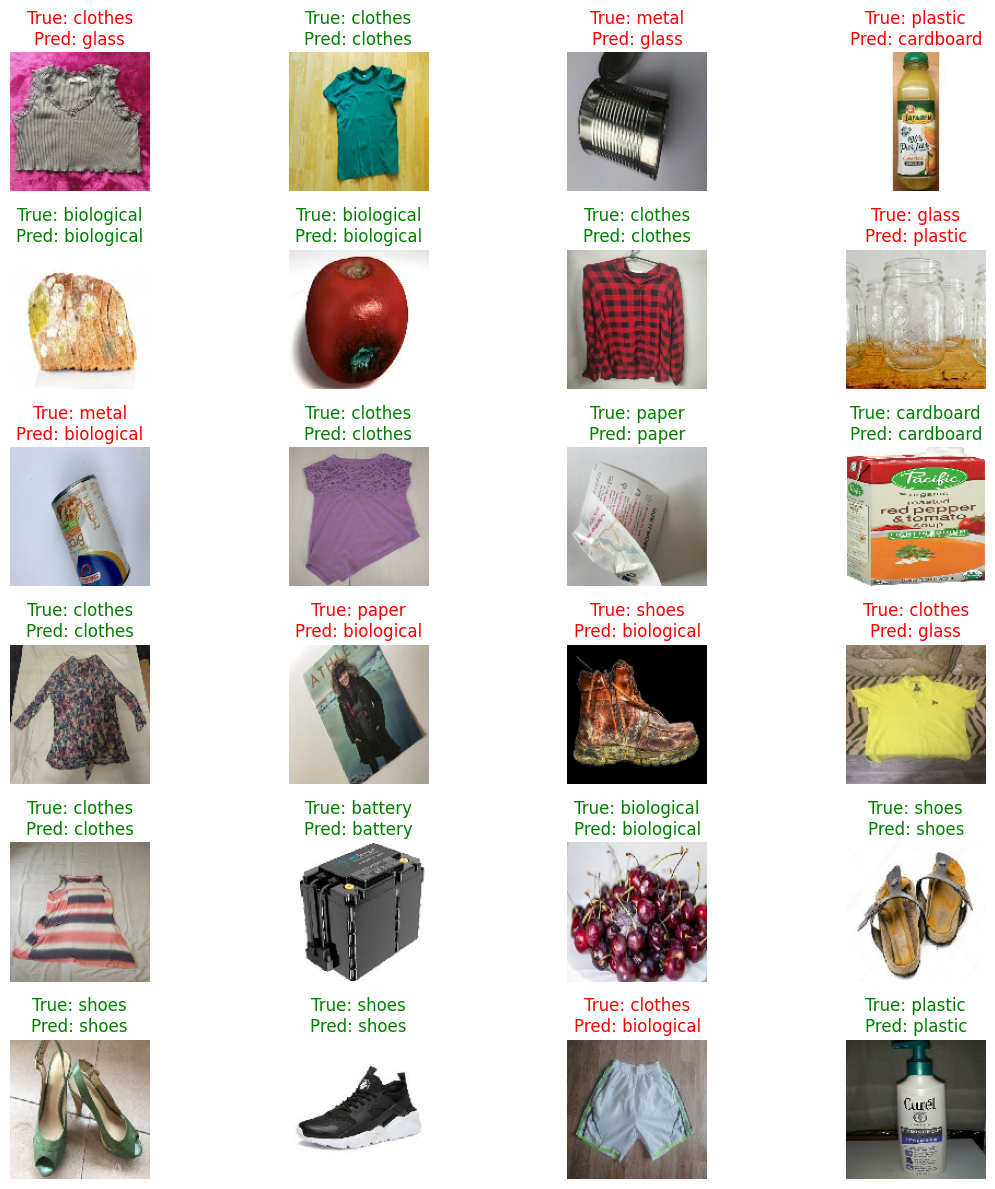

In [11]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Visualize some predictions
import numpy as np

# Use the already defined class_names variable
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(24):
        plt.subplot(6, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()